# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
# Import libraries and define functions

In [1]:
# Import necessary libraries

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Define functions used in this Jupyter notebook

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def lane_det_binary(img, thresh=(0, np.pi/2), s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    r_channel = img[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel
    sobelx = cv2.Sobel(r_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(r_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold direction gradient (ended up not using this)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    d_binary =  np.zeros_like(absgraddir)
    d_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
    
    # Combine the binary thresholds desired
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[(s_binary == 1) | (sx_binary == 1)] = 1
    
    return combined_binary

def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def region_of_interest(img, vertices):

    # Define a blank mask to start with
    mask = np.zeros_like(img)   
    img_size = (img.shape[1], img.shape[0])
    
    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Apply mask to region outside vertices  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    roi = cv2.bitwise_and(img, mask)
    src = np.float32([[180,img_size[1]],[590, 450], [690, 450], [1100,img_size[1]]])
    dst = np.float32([[250,img_size[1]],[250,0],[1010,0],[1010,img_size[1]]])
    bird_eye = warper(img, src, dst)
    
    return roi, bird_eye

def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]//2) # Assuming camera is mounted at the center of the car
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 8
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin 
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on new position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find lane pixels using sliding window method first
    leftx, lefty, rightx, righty, out_img = sliding_window(binary_warped)

    # Fit a second order polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fit, right_fit, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Very similar logic to fit_polynomial but with different inputs
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def measure_curvature_real(left_fit, right_fit):

    # Define conversions in x and y from pixels space to meters
    my = 30/720 # meters per pixel in y dimension
    mx = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    y_eval = 360
    
    # Implement radius of curvature calculation
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_curverad = ((1 + (2 * mx / (my ** 2) * left_fit[0] * y_eval + mx / my * left_fit[1])**2)**(3/2)) / (np.absolute(2*mx / (my ** 2) * left_fit[0]))
    right_curverad = ((1 + (2 * mx / (my ** 2) * right_fit[0] * y_eval + mx / my * right_fit[1])**2)**(3/2)) / (np.absolute(2 * mx / (my ** 2) * right_fit[0]))
    
    return left_curverad, right_curverad

def search_around_poly(left_fit, right_fit, binary_warped, new_bird_eye):
    # HYPERPARAMETER
    # Set margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    output = np.copy(new_bird_eye)
    window_img = np.zeros_like(out_img)
    lane_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    left_lane = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_lane = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
                              ploty])))])
    lane_pts = np.hstack((left_lane, right_lane))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    cv2.fillPoly(lane_img, np.int_([lane_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    lane = cv2.addWeighted(out_img, 1, lane_img, 0.3, 0)
    
    
    # Plot the polynomial lines onto the image
    yellow_left = plt.plot(left_fitx, ploty, color='yellow')
    yellow_right = plt.plot(right_fitx, ploty, color='yellow')

    ## End visualization steps ##
    
    # Calculate center of lane
    center = (left_fitx[len(ploty)-1] + right_fitx[len(ploty)-1]) / 2
    
    # Compute distance from center in meters
    dist = np.absolute((binary_warped.shape[1]/2) - center) * 3.7/700
    
    # Calculate radius of curvature of lane at bottom of image
    left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit)
    radius = (left_curverad + right_curverad) / 2
    
    return left_fit, right_fit, lane, result, radius, dist

def pre_processing(new_image):
    # Function used to process new images, such as frames of input video
    image = cal_undistort(new_image, objpoints, imgpoints) # Undistort function
    imshape = new_image.shape # Obtain height and width of image
    new_roi, new_bird_eye = region_of_interest(image, vertices) # Apply mask and transform
    new_lane_binary = lane_det_binary(new_bird_eye, s_thresh=(160, 240), sx_thresh=(50, 100)) # Apply binary threshold
    return new_lane_binary, new_bird_eye

def post_processing(original, lane, radius, dist):
    # Function used to unwarp results and print radius of curvature and distance from center onto final frames
    img_size = (lane.shape[1], lane.shape[0])
    src = np.float32([[180,img_size[1]],[590, 450], [690, 450], [1100,img_size[1]]])
    dst = np.float32([[250,img_size[1]],[250,0],[1010,0],[1010,img_size[1]]])
    final_result = unwarper(lane, src, dst)
    final_result = cv2.addWeighted(original, 1, final_result, 0.5, 0)

    cv2.putText(final_result, "Radius of Curvature: {} m".format(round(radius, 2)), (20, 60), cv2.FONT_HERSHEY_DUPLEX, 2.0, (0, 0, 0))
    cv2.putText(final_result, "Distance from center: {} m".format(round(dist, 2)), (20, 120), cv2.FONT_HERSHEY_DUPLEX, 2.0, (0, 0, 0))

    return final_result

## First, I'll compute the camera calibration using chessboard images

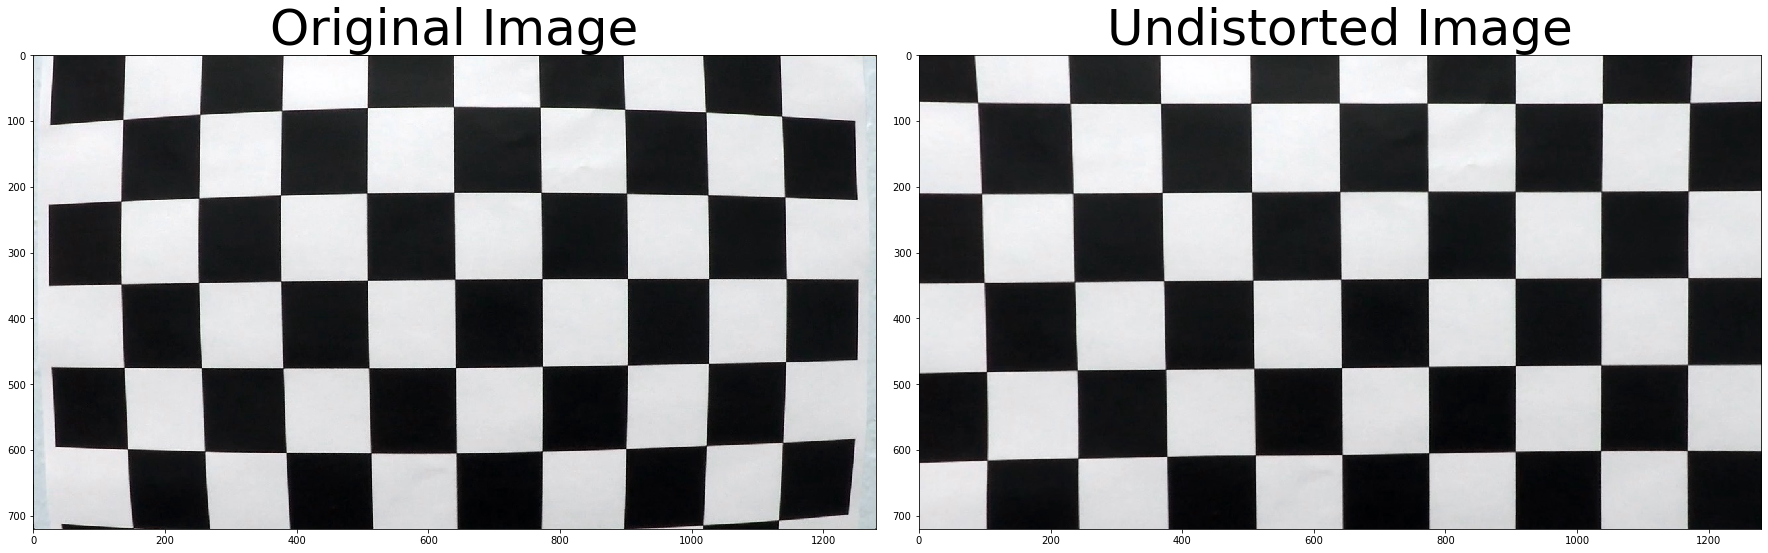

In [3]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Load test image 
img_test = cv2.imread('./camera_cal/calibration1.jpg')

# Apply calibration and undistort image
undistorted = cal_undistort(img_test, objpoints, imgpoints)

# Display original and undistorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_test)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## Then, I'll apply the distortion correction, and perspective transform

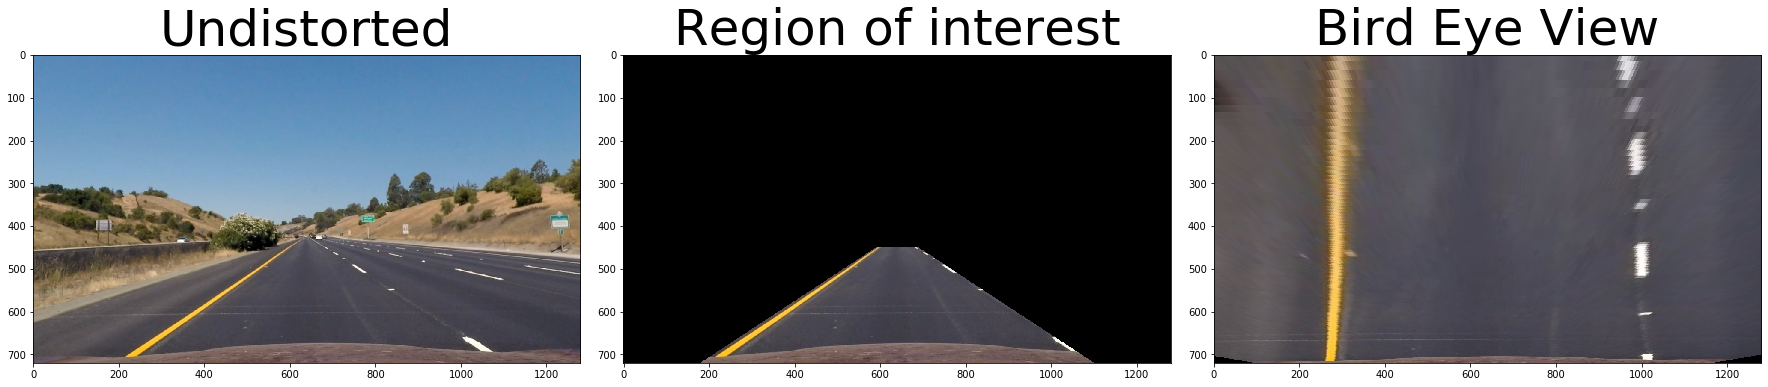

In [23]:
# Read image of straight lines to select region of interest
image = mpimg.imread('./test_images/straight_lines1.jpg')
image = cal_undistort(image, objpoints, imgpoints) # Undistort function
imshape = image.shape #Obtain height and width of image

# Specify vertices of ROI
vertices = np.array([[(180,imshape[0]),(590, 450), (690, 450), (1100,imshape[0])]], dtype=np.int32)
roi, bird_eye = region_of_interest(image, vertices)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Undistorted', fontsize=50)

ax2.imshow(roi)
ax2.set_title('Region of interest', fontsize=50)

ax3.imshow(bird_eye)
ax3.set_title('Bird Eye View', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


---
## Apply several thresholds to accurately detect lanes

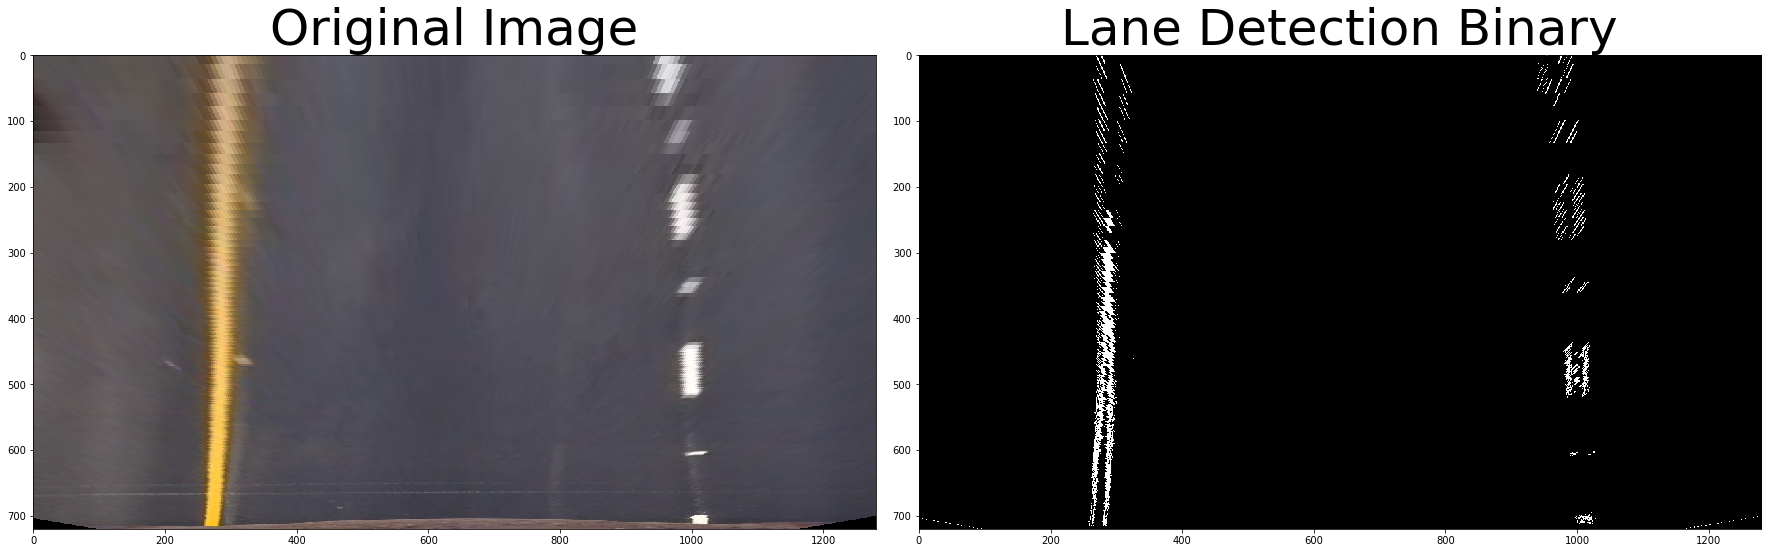

In [5]:
# Apply thresholds on bird-eye view image
lane_binary = lane_det_binary(bird_eye, s_thresh=(160, 240), sx_thresh=(50, 100))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bird_eye)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(lane_binary, cmap='gray')
ax2.set_title('Lane Detection Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## Use sliding windows method to fit first polynomial

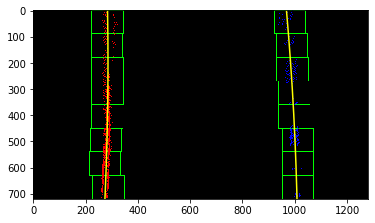

In [25]:
left_fit, right_fit, out_img = fit_polynomial(lane_binary)
plt.imshow(out_img)

---
## After estimating first polynomial, apply search near previous polynomial method

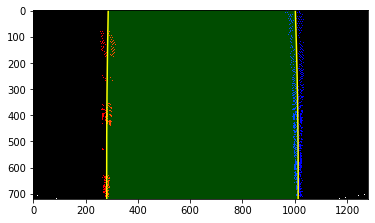

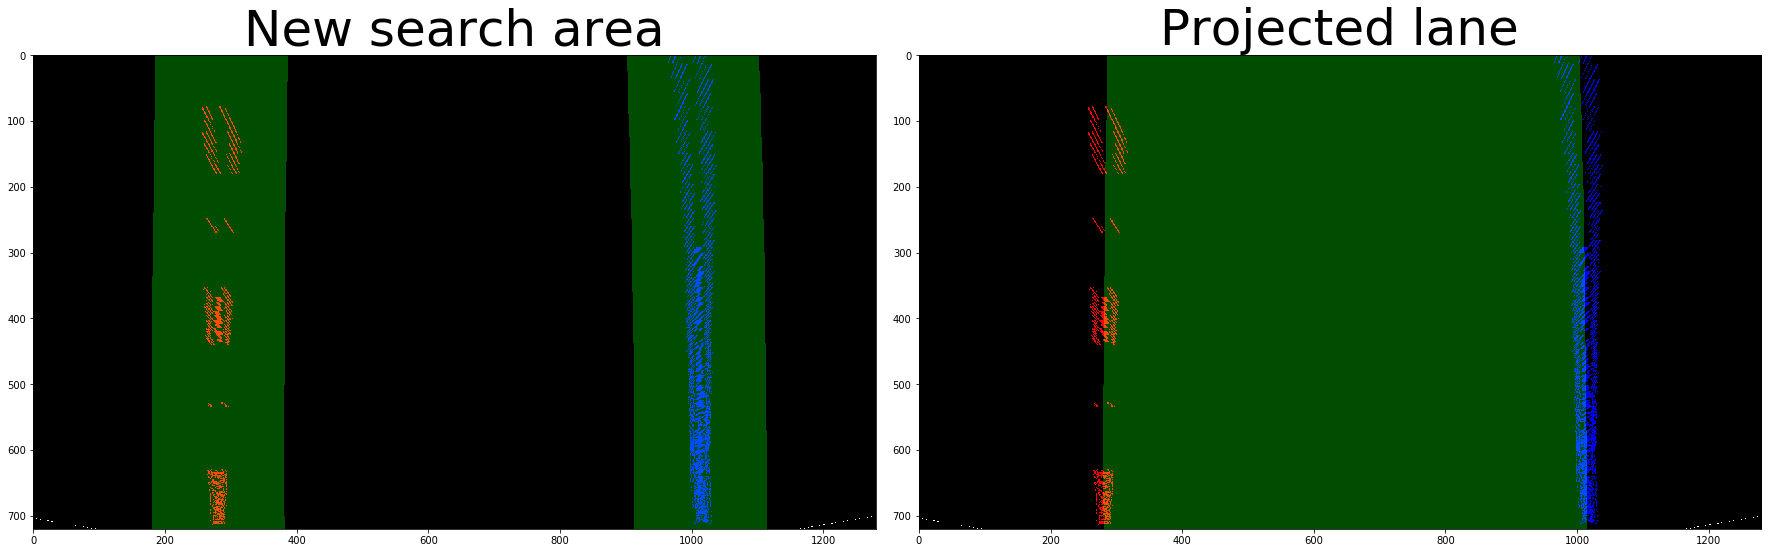

In [26]:
new_image = mpimg.imread('./test_images/straight_lines2.jpg')
binary, perspective = pre_processing(new_image)

# Run image through the pipeline
l, r, lane, result, radius, dist = search_around_poly(left_fit, right_fit, binary, perspective)
left_fit = l
right_fit = r

plt.imshow(lane)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(result)
ax1.set_title('New search area', fontsize=50)

ax2.imshow(lane)
ax2.set_title('Projected lane', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

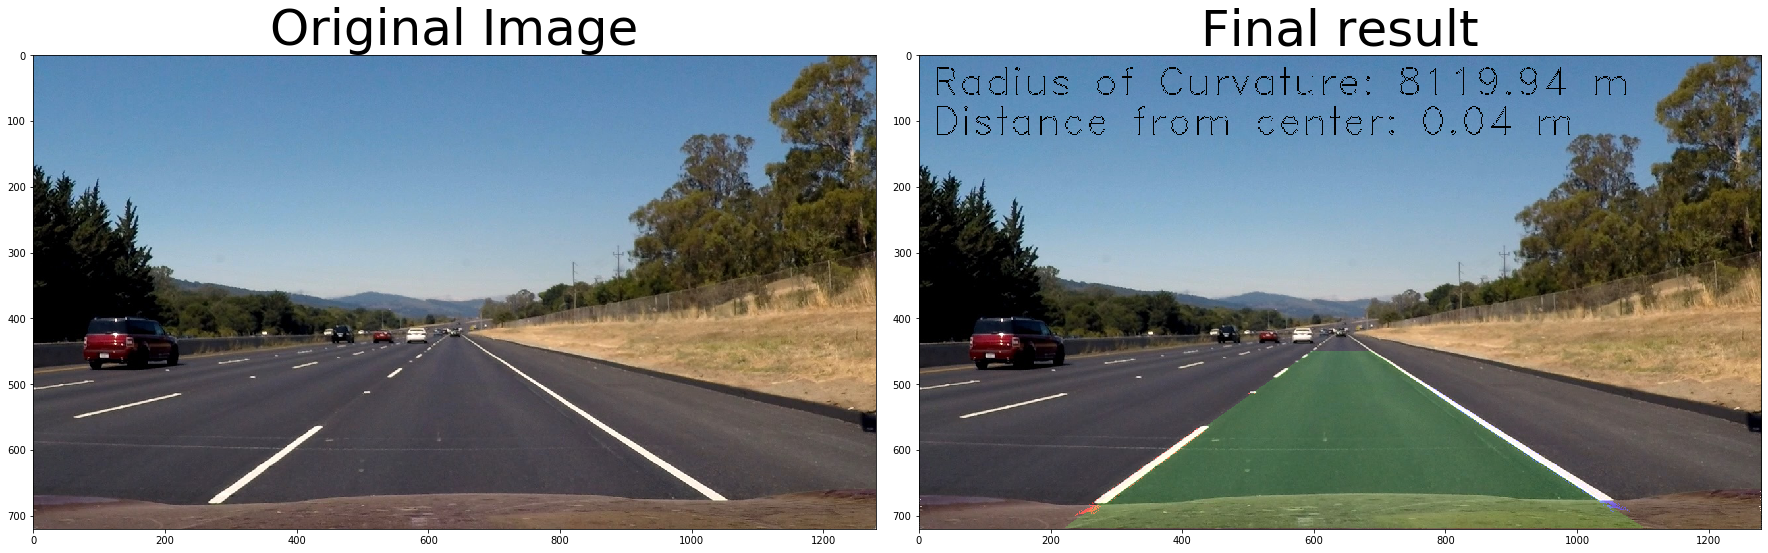

In [27]:
final_result = post_processing(new_image, lane, radius, dist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(new_image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(final_result)
ax2.set_title('Final result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [28]:
def process_video(frame, left_fit, right_fit):
    binary, perspective = pre_processing(frame)
    l, r, lane, result, radius, dist = search_around_poly(left_fit, right_fit, binary, perspective)
    left_fit = l
    right_fit = r
    final_result = post_processing(frame, lane, radius, dist)
    return final_result, left_fit, right_fit

Done!


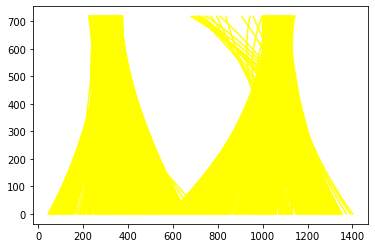

In [29]:
cap = cv2.VideoCapture("project_video.mp4")
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('output_images/challenge_video_test.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 25,
(frame_width, frame_height))
left_fit, right_fit, out_img = fit_polynomial(lane_binary)
try:
    while True:
        ret, frame = cap.read()
        final_result, l, r = process_video(frame, left_fit, right_fit)
        left_fit = l
        right_fit = r
        out.write(final_result)
except:
    pass
cap.release()
out.release()
print('Done!')